In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [12]:
# 데이터 불러오기
train, valid = tfds.load(
	"div2k/bicubic_x4",
    split = ["train", "validation"],
    as_supervised=True
    )

2022-10-27 13:20:43.021916: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /home/soohyoen/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteIGXG3X/div2k-train.tfrecord*...:…

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /home/soohyoen/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteIGXG3X/div2k-validation.tfrecord…

Dataset div2k downloaded and prepared to /home/soohyoen/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


2022-10-27 13:33:14.857811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 13:33:14.858188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/soohyoen/anaconda3/envs/yolov5/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-10.2/lib64:
2022-10-27 13:33:14.858248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/soohyoen/anaconda3/envs/yolov5/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-10.2/lib64:
2022-10-27 13:33:14.858290: W tensorflow/stream_executor/platform/defa

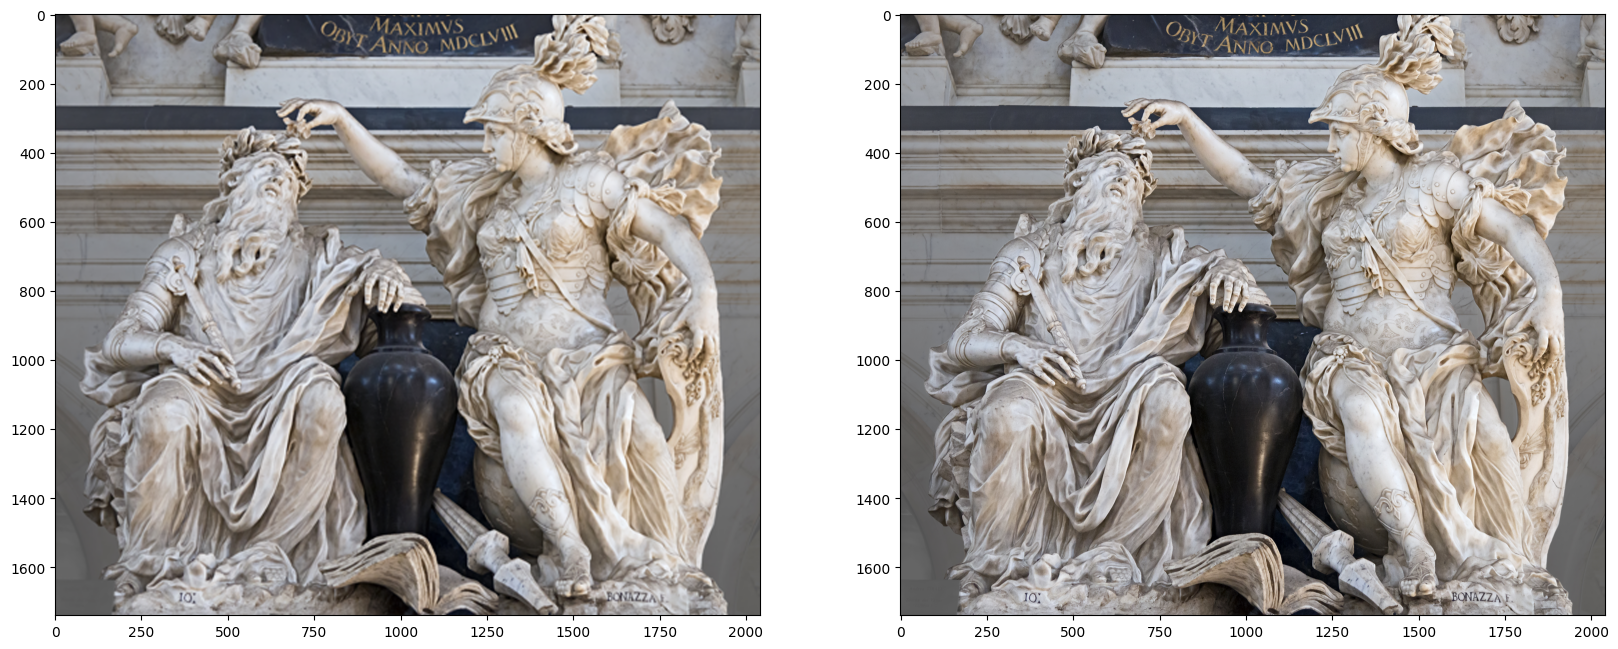

In [30]:
# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 6: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.
hr, lr = np.array(hr), np.array(lr)

bicubic_hr = cv2.resize(
    lr,
    dsize=(hr.shape[1], hr.shape[0]), #고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)   

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

Text(0.5, 1.0, 'HR')

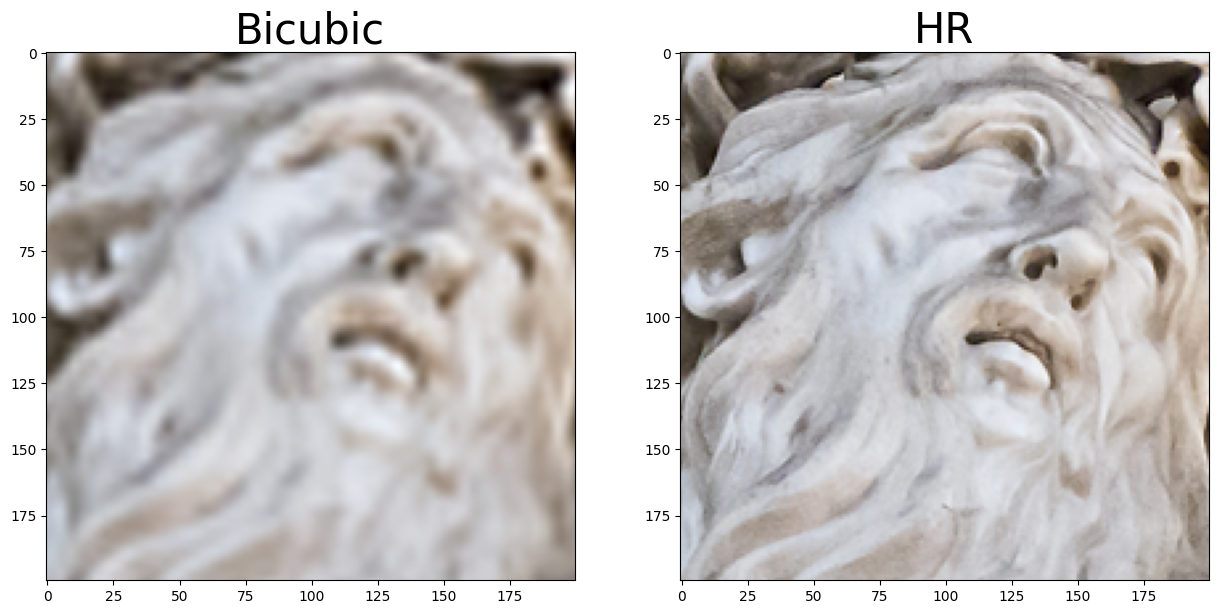

In [45]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.

def crop(image, left_top, x=200, y=200):
    
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y),:]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400,500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

In [48]:
def preprocessing(lr, hr):
	# 이미지의 크기가 크므로 (96, 96, 3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr
    
train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)


In [113]:
from tensorflow.keras import layers, Sequential

# 3개의 Conv layer를 갖는 Sequential 모델을 구성
srcnn = Sequential()

# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128,9,padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())

# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())

# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 128)   31232     
                                                                 
 re_lu_3 (ReLU)              (None, None, None, 128)   0         
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 re_lu_4 (ReLU)              (None, None, None, 64)    0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [124]:
srcnn.compile(optimizer="adam",
    loss="mse"
    )
    
srcnn.fit(train, validation_data=valid, epochs=20)


Epoch 1/20
50/50 [==============================] - 68s 1s/step - loss: 0.0126 - val_loss: 0.0060
Epoch 2/20
50/50 [==============================] - 68s 1s/step - loss: 0.0065 - val_loss: 0.0066
Epoch 3/20
50/50 [==============================] - 68s 1s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 4/20
50/50 [==============================] - 69s 1s/step - loss: 0.0047 - val_loss: 0.0038
Epoch 5/20
50/50 [==============================] - 67s 1s/step - loss: 0.0043 - val_loss: 0.0044
Epoch 6/20
50/50 [==============================] - 69s 1s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 7/20
50/50 [==============================] - 68s 1s/step - loss: 0.0046 - val_loss: 0.0037
Epoch 8/20
50/50 [==============================] - 69s 1s/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/20
50/50 [==============================] - 69s 1s/step - loss: 0.0043 - val_loss: 0.0038
Epoch 10/20
50/50 [==============================] - 68s 1s/step - loss: 0.0044 - val_loss: 0.0046
Epoch 11/20
50/50 [

In [125]:
srcnn.save_weights("srcnn.h5")

In [126]:
model_json = srcnn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
 

In [127]:
from tensorflow.keras.models import model_from_json

In [128]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("srcnn.h5")
print("Loaded model from disk")

Loaded model from disk


In [129]:
def apply_srcnn(image):
    sr = loaded_model.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

In [130]:
srcnn_hr = apply_srcnn(bicubic_hr)

2022-10-27 15:40:34.427156: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1817395200 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step


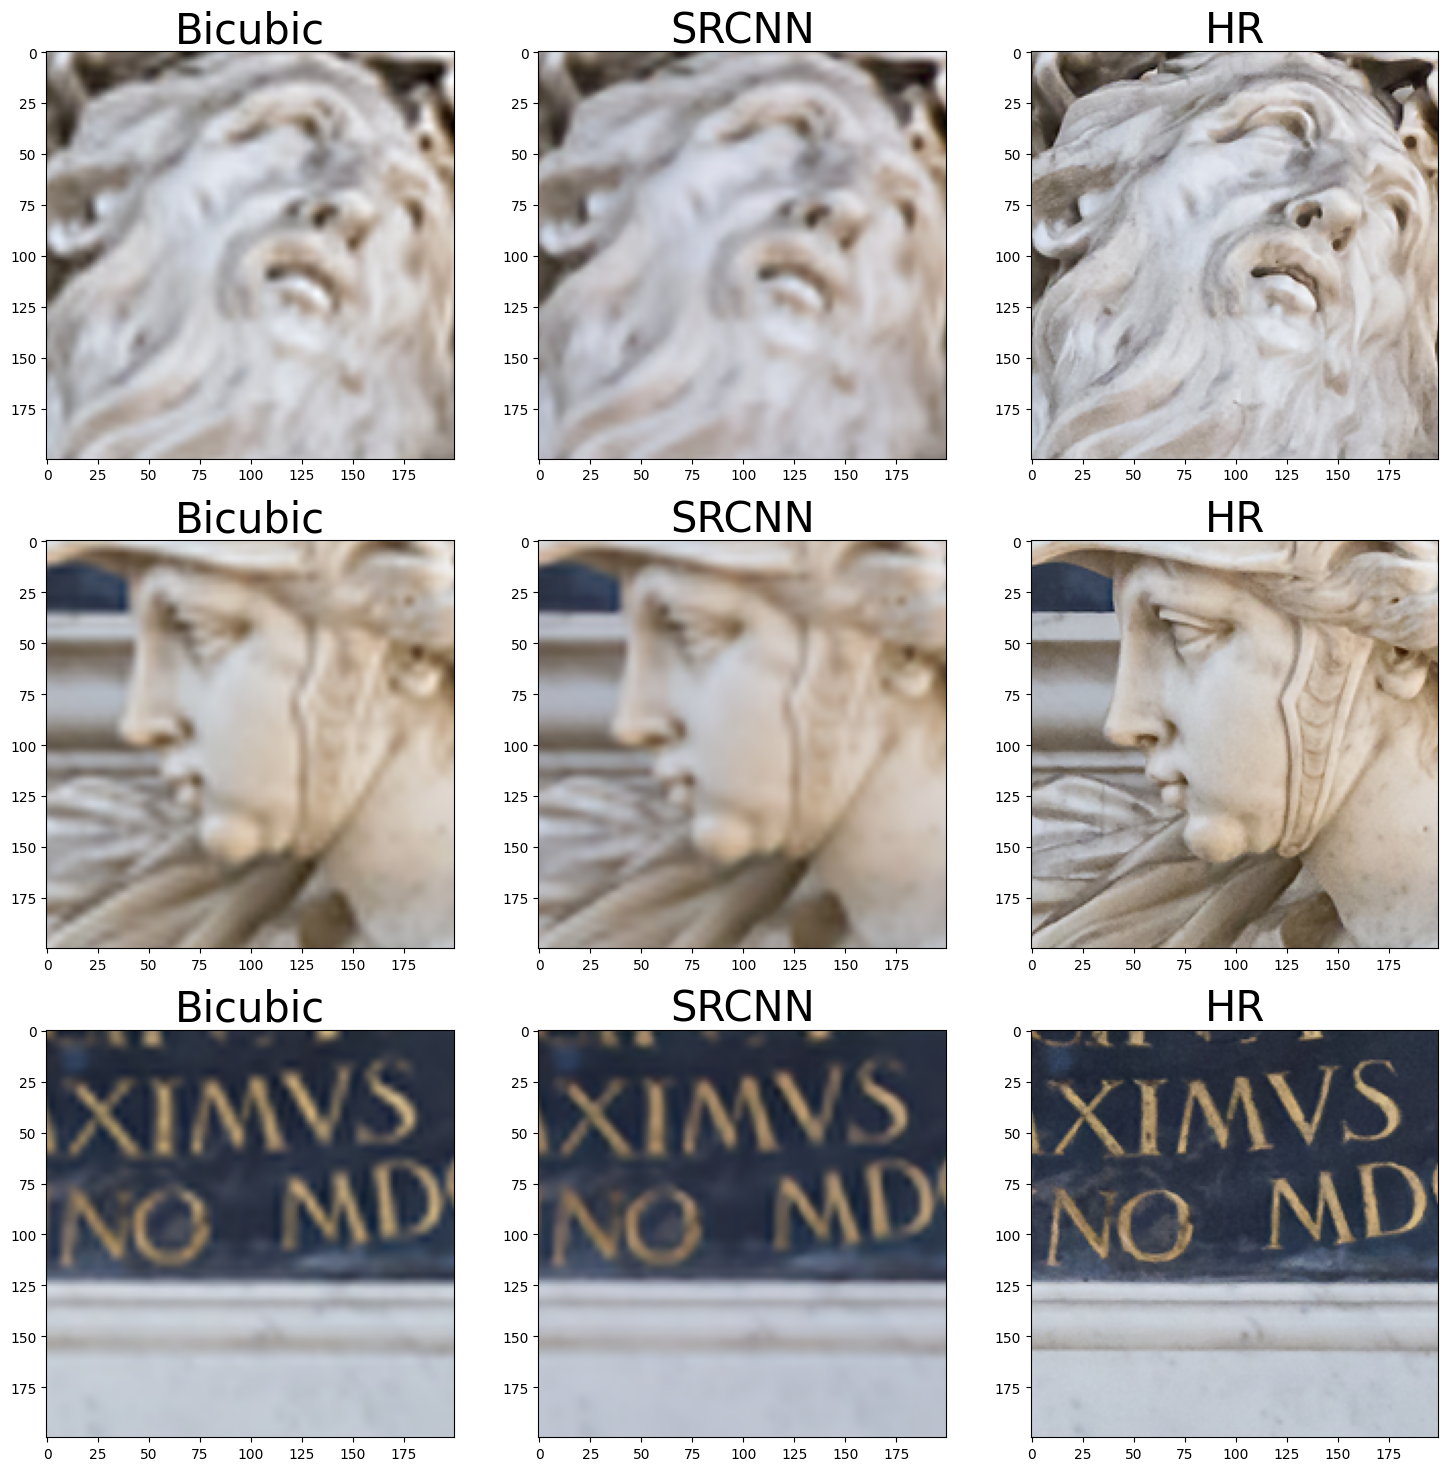

In [131]:
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr, left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])
        
labels = ["Bicubic", "SRCNN", "HR"] * 3 

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)